In [1]:
import os
os.getcwd()
os.chdir("/mnt/workspace/Public-DSC291/notebooks/Section2-PCA/Full_Dataset_analysis")
os.getcwd()


'/mnt/workspace/Public-DSC291/notebooks/Section2-PCA/Full_Dataset_analysis'

In [2]:
from Startup import *

finished standard imports
dict_items([('spark.default.parallelism', '10'), ('spark.cores.max', '4'), ('spark.logConf', 'True'), ('spark.executor.memory', '3g'), ('spark.executor.cores', '1'), ('spark.app.name', 'Weather_PCA')])
started SparkContext and SQLContext in 15.73 seconds
loaded weather.parquet in 7.77 seconds
loaded stations.parquet in 0.16 seconds
registered dataframes as tables in 0.21 seconds


In [3]:
%%time
print('df has %d rows, stations has %d rows'%(df.count(),stations.count()))

df has 9358394 rows, stations has 85284 rows
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.39 s


## get california data

In [4]:
%%time
query="""
SELECT stations.ID, stations.elevation, stations.state
FROM stations
WHERE stations.state='CA'
"""
print(query)
CA_df=sqlContext.sql(query)
sqlContext.registerDataFrameAsTable(CA_df,'CA_df')
CA_pdf=CA_df.toPandas()


SELECT stations.ID, stations.elevation, stations.state
FROM stations
WHERE stations.state='CA'

CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 646 ms


In [5]:
CA_pdf.head()

,ID,elevation,state
0,USC00040006,601.1,CA
1,USC00040010,26.5,CA
2,USC00040014,863.5,CA
3,USC00040024,869.0,CA
4,USC00040029,1278.6,CA


## now get all weather data for california

In [6]:
%%time
query="""
SELECT stations.ID, stations.elevation, stations.state, 
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state='CA' AND weather.Measurement='SNOW'
"""

print(query)
CA_weather_df=sqlContext.sql(query)
CA_weather_pdf=CA_weather_df.toPandas()
sqlContext.registerDataFrameAsTable(CA_weather_df,'CA_weather_df')
# CA_weather_df.show()
CA_weather_pdf.head()


SELECT stations.ID, stations.elevation, stations.state, 
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state='CA' AND weather.Measurement='SNOW'

CPU times: user 448 ms, sys: 40 ms, total: 488 ms
Wall time: 36.8 s


In [7]:
CA_weather_pdf.head()

,ID,elevation,state,Station,Measurement,Year,Values
0,USC00042239,1414.3,CA,USC00042239,SNOW,1899,"[0, 0, 64, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,USC00042239,1414.3,CA,USC00042239,SNOW,1900,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12..."
2,USC00042239,1414.3,CA,USC00042239,SNOW,1901,"[64, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,USC00042239,1414.3,CA,USC00042239,SNOW,1902,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12..."
4,USC00042239,1414.3,CA,USC00042239,SNOW,1903,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12..."


## okay let's look at total snowpack for 1997

In [8]:
totalSnowpack1997 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1997)] # 43886 measurements
totalSnowpack1997.head()

,ID,elevation,state,Station,Measurement,Year,Values
97,USC00042239,1414.3,CA,USC00042239,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0,..."
131,USC00045790,75.0,CA,USC00045790,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
207,USC00042574,661.4,CA,USC00042574,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
308,USC00046960,563.9,CA,USC00046960,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
424,USC00047672,424.3,CA,USC00047672,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
import matplotlib.pyplot as plt

def totalSnowFall(row):
    row = row.to_frame()
    L = list(row.transpose()['Values'])
    asf = np.stack([unpackArray(v, np.float16) for v in L])
    return np.nansum(asf[0])

totalSnowpack1997['totalSnow'] = totalSnowpack1997.apply (lambda row: totalSnowFall(row), axis=1)
# totalSnowpack1997.sort_values(by='totalSnow', ascending=False)

totalSnowpack1998 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1998)]
totalSnowpack1998['totalSnow'] = totalSnowpack1998.apply (lambda row: totalSnowFall(row), axis=1)

snowAllYears = pd.concat([totalSnowpack1997, totalSnowpack1998])
snowAllYears

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,elevation,state,Station,Measurement,Year,Values,totalSnow
97,USC00042239,1414.3,CA,USC00042239,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0,...",248.0
131,USC00045790,75.0,CA,USC00045790,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
207,USC00042574,661.4,CA,USC00042574,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",241.0
308,USC00046960,563.9,CA,USC00046960,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
424,USC00047672,424.3,CA,USC00047672,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
508,USC00047851,93.9,CA,USC00047851,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
570,USW00093115,7.3,CA,USW00093115,SNOW,1997,"[0, 126, 0, 0, 0, 0, 0, 126, 0, 126, 0, 0, 0, ...",0.0
599,USC00049440,68.3,CA,USC00049440,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
687,USC00047085,1478.3,CA,USC00047085,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
790,USC00046168,27.4,CA,USC00046168,SNOW,1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


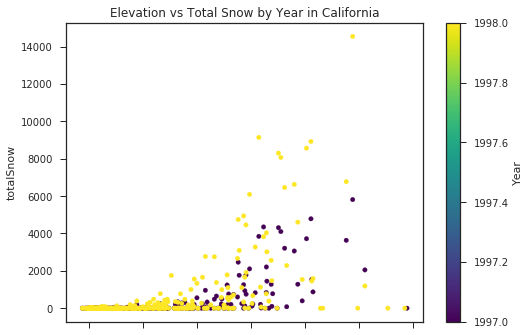

In [119]:
lines = snowAllYears.plot.scatter(x='elevation', y='totalSnow', c='Year', colormap='viridis',
                                 title='Elevation vs Total Snow by Year in California')
plt.show()

In [10]:
totalSnowpack1995 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1995)]
totalSnowpack1995['totalSnow'] = totalSnowpack1995.apply (lambda row: totalSnowFall(row), axis=1)

totalSnowpack1996 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1996)]
totalSnowpack1996['totalSnow'] = totalSnowpack1996.apply (lambda row: totalSnowFall(row), axis=1)

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
totalSnowpack1996.head()

,ID,elevation,state,Station,Measurement,Year,Values,totalSnow
96,USC00042239,1414.3,CA,USC00042239,SNOW,1996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",590.0
130,USC00045790,75.0,CA,USC00045790,SNOW,1996,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12...",0.0
206,USC00042574,661.4,CA,USC00042574,SNOW,1996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1263.0
307,USC00046960,563.9,CA,USC00046960,SNOW,1996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
423,USC00047672,424.3,CA,USC00047672,SNOW,1996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


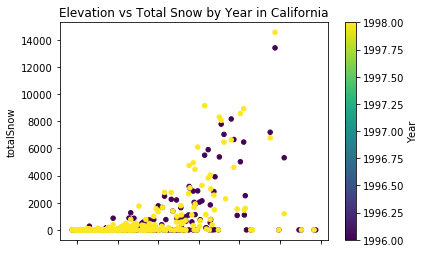

In [12]:
snowAllYears = pd.concat([totalSnowpack1996, totalSnowpack1998])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='totalSnow', c='Year', colormap='viridis',
                                 title='Elevation vs Total Snow by Year in California')
plt.show()

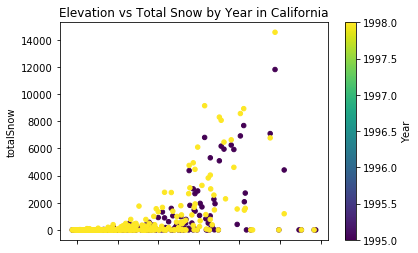

In [14]:
snowAllYears = pd.concat([totalSnowpack1995, totalSnowpack1998])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='totalSnow', c='Year', colormap='viridis',
                                 title='Elevation vs Total Snow by Year in California')
plt.show()

## just look at feb snowfall

In [15]:
def febSnowFall(row):
    row = row.to_frame()
    L = list(row.transpose()['Values'])
    asf = np.stack([unpackArray(v, np.float16) for v in L])
    return np.nansum(asf[0][30:60])

totalSnowpack1995['febSnow'] = totalSnowpack1995.apply (lambda row: febSnowFall(row), axis=1)

totalSnowpack1996['febSnow'] = totalSnowpack1996.apply (lambda row: febSnowFall(row), axis=1)

totalSnowpack1997['febSnow'] = totalSnowpack1997.apply (lambda row: febSnowFall(row), axis=1)

totalSnowpack1998['febSnow'] = totalSnowpack1998.apply (lambda row: febSnowFall(row), axis=1)

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

In [16]:
totalSnowpack1996.head()

,ID,elevation,state,Station,Measurement,Year,Values,totalSnow,febSnow
96,USC00042239,1414.3,CA,USC00042239,SNOW,1996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",590.0,499.0
130,USC00045790,75.0,CA,USC00045790,SNOW,1996,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12...",0.0,0.0
206,USC00042574,661.4,CA,USC00042574,SNOW,1996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1263.0,662.0
307,USC00046960,563.9,CA,USC00046960,SNOW,1996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0
423,USC00047672,424.3,CA,USC00047672,SNOW,1996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0


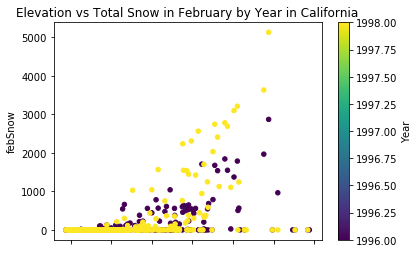

In [21]:
snowAllYears = pd.concat([totalSnowpack1996, totalSnowpack1998])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='febSnow', c='Year', colormap='viridis',
                                 title='Elevation vs Total Snow in February by Year in California')
plt.show()

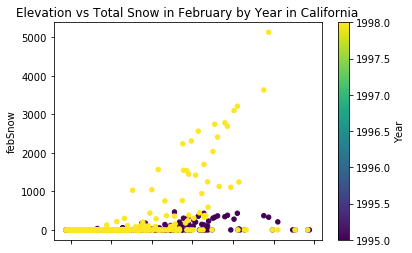

In [20]:
snowAllYears = pd.concat([totalSnowpack1995, totalSnowpack1998])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='febSnow', c='Year', colormap='viridis',
                                 title='Elevation vs Total Snow in February by Year in California')
plt.show()

## now let's do it for '80 vs 82/83

In [109]:
totalSnowpack1980 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1980)]
totalSnowpack1980['totalSnow'] = totalSnowpack1980.apply (lambda row: totalSnowFall(row), axis=1)

totalSnowpack1981 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1981)]
totalSnowpack1981['totalSnow'] = totalSnowpack1981.apply (lambda row: totalSnowFall(row), axis=1)

totalSnowpack1982 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1982)]
totalSnowpack1982['totalSnow'] = totalSnowpack1982.apply (lambda row: totalSnowFall(row), axis=1)

totalSnowpack1983 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1983)]
totalSnowpack1983['totalSnow'] = totalSnowpack1983.apply (lambda row: totalSnowFall(row), axis=1)


/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [110]:
totalSnowpack1980.head()

,ID,elevation,state,Station,Measurement,Year,Values,totalSnow
80,USC00042239,1414.3,CA,USC00042239,SNOW,1980,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",608.0
114,USC00045790,75.0,CA,USC00045790,SNOW,1980,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
190,USC00042574,661.4,CA,USC00042574,SNOW,1980,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",114.0
291,USC00046960,563.9,CA,USC00046960,SNOW,1980,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
407,USC00047672,424.3,CA,USC00047672,SNOW,1980,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


In [111]:
totalSnowpack1980 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1980)]
totalSnowpack1980['febSnow'] = totalSnowpack1980.apply (lambda row: febSnowFall(row), axis=1)

totalSnowpack1981 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1981)]
totalSnowpack1981['febSnow'] = totalSnowpack1981.apply (lambda row: febSnowFall(row), axis=1)

totalSnowpack1982 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1982)]
totalSnowpack1982['febSnow'] = totalSnowpack1982.apply (lambda row: febSnowFall(row), axis=1)

totalSnowpack1983 = CA_weather_pdf.loc[(CA_weather_pdf['Year'] == 1983)]
totalSnowpack1983['febSnow'] = totalSnowpack1983.apply (lambda row: febSnowFall(row), axis=1)

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [106]:
snowAllYears = pd.concat([totalSnowpack1980, totalSnowpack1982])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='totalSnow', c='Year', colormap='viridis')
plt.show()

KeyError: 'totalSnow'

In [104]:
snowAllYears = pd.concat([totalSnowpack1981, totalSnowpack1983])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='totalSnow', c='Year', colormap='viridis')
plt.show()

KeyError: 'totalSnow'

## feb snowfall

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


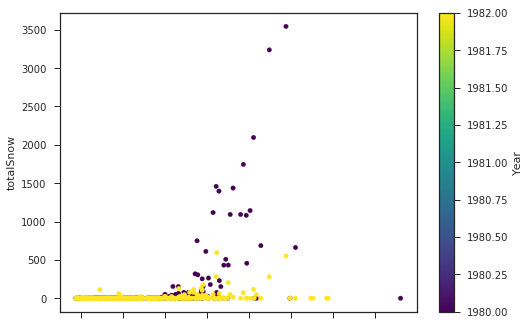

In [90]:
snowAllYears = pd.concat([totalSnowpack1980, totalSnowpack1982])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='febSnow', c='Year', colormap='viridis')
plt.show()

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


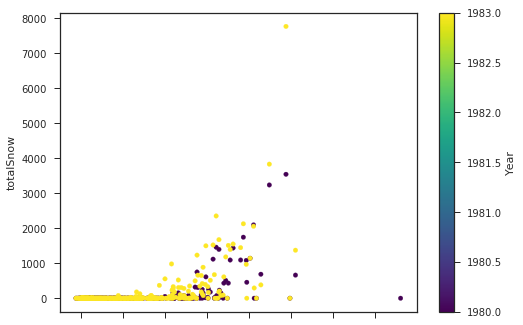

In [91]:
snowAllYears = pd.concat([totalSnowpack1980, totalSnowpack1983])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='totalSnow', c='Year', colormap='viridis')
plt.show()

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


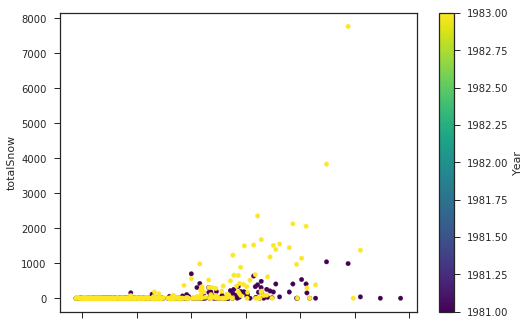

In [92]:
snowAllYears = pd.concat([totalSnowpack1981, totalSnowpack1983])
# snowAllYears

lines = snowAllYears.plot.scatter(x='elevation', y='totalSnow', c='Year', colormap='viridis')
plt.show()